In [132]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import pandas as pd 
from pandas.api.types import CategoricalDtype
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
from scipy.stats import iqr

colour_pal = sns.color_palette('flare')

Custom Function for Calculating Mean Absolute Percentage Error

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Load DataSet (PJM East)

In [7]:
pjme = pd.read_csv('DataSet/Regions/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head(10)


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


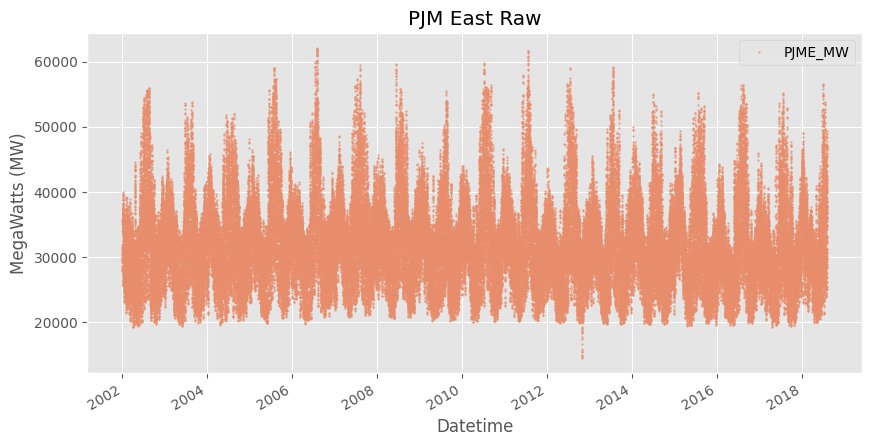

In [16]:
pjme.plot(style='.', figsize=(10,5),ms=1, color=colour_pal,ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.show()

### Outlier Analysis and Removal 

In [17]:
pjme.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


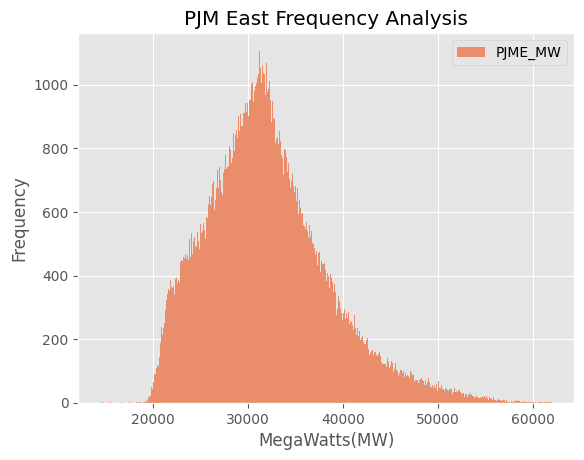

In [21]:
pjme.plot(kind='hist', bins=500, color=colour_pal,xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

In [28]:
iqr_value = iqr(pjme['PJME_MW'])
lower_threshold = np.quantile(pjme['PJME_MW'], 0.25) - ((1.5) * (iqr_value))
upper_threshold = np.quantile(pjme['PJME_MW'], 0.75) + ((1.5) * (iqr_value))

print('Outlier threshold calculations:',f'IQR: {iqr_value}', f'Lower threshold:{lower_threshold}', f'Upper threshold: {upper_threshold}')

Outlier threshold calculations: IQR: 8077.0 Lower threshold:15457.5 Upper threshold: 47765.5


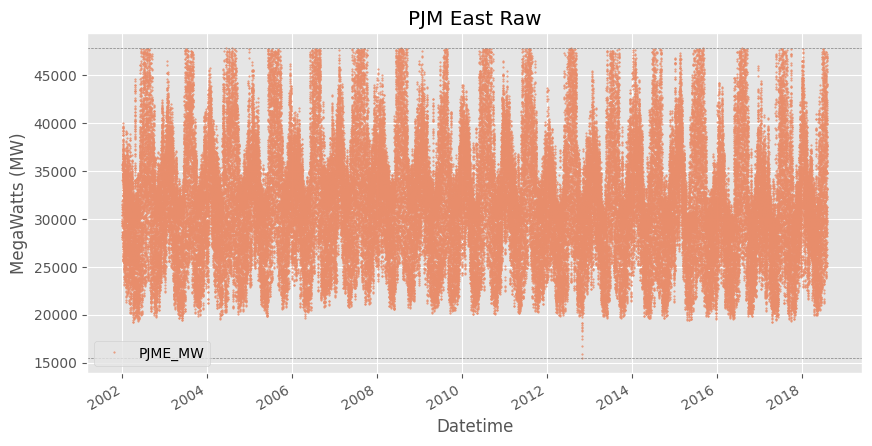

In [35]:
pjme.plot(style='.', figsize=(10, 5), ms=1, color=colour_pal,
          ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.axhline(y=upper_threshold, color='grey', linestyle='--',linewidth=0.5)
plt.axhline(y=lower_threshold, color='grey', linestyle='--', linewidth=0.5)
plt.show()

In [36]:
pjme = pjme.query('PJME_MW <= @upper_threshold and PJME_MW >= @lower_threshold').copy()

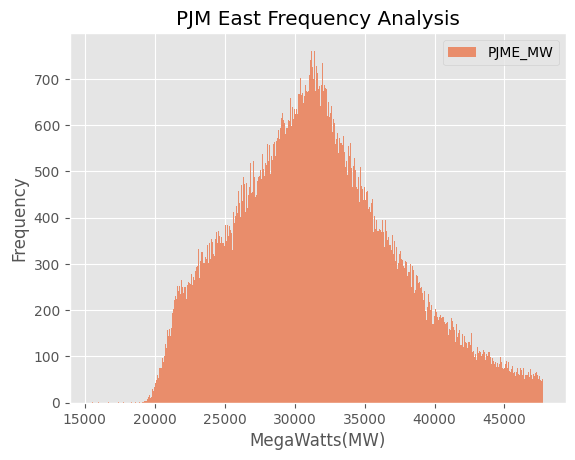

In [37]:
pjme.plot(kind='hist', bins=500, color=colour_pal, xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

### Feature Creation

In [39]:
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                        'Wednesday',
                                        'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                            ordered=True)

In [45]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                          )
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekday',
            'season']]
    if label:
        y = df[label]
        return X, y
    return X

In [46]:
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

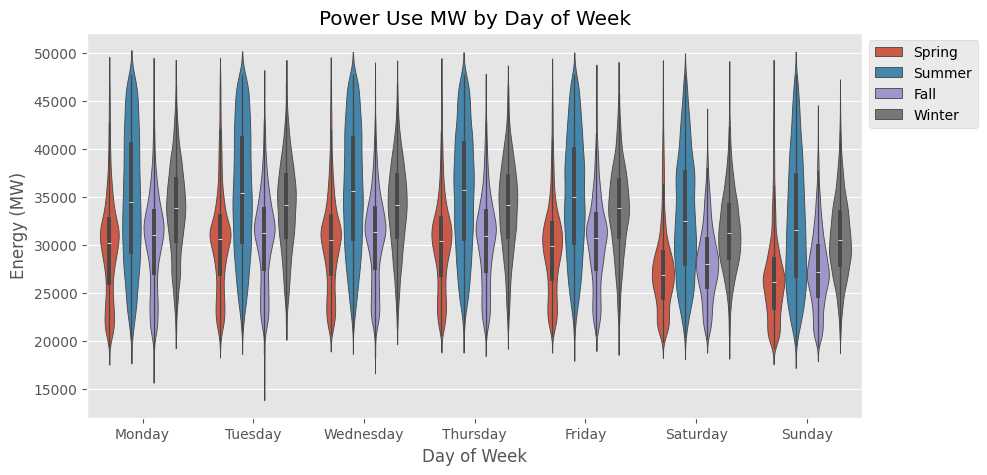

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Add Holidays

In [133]:
cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})

#### Correlation Analysis
- environmental factors
- holidays
- employment vs unemployment
- density of people / number of people in a house hold
- types of energy productions
- use heat maps and scatter plots to determine the correlatins and if relevant

### Train/Test Split
- will split train and test on Jan 01  (80:20 split)


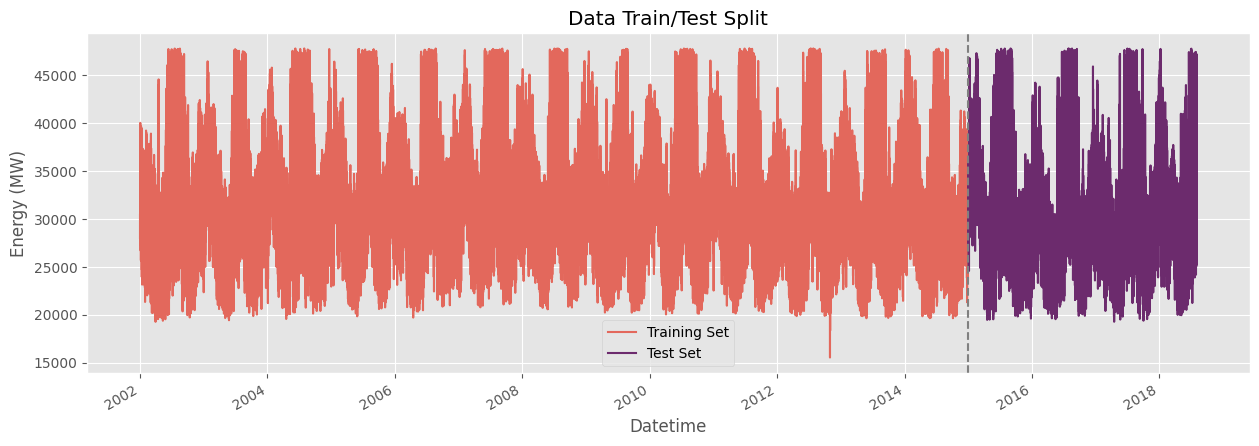

In [134]:
pjme_train = pjme.loc[pjme.index < '01-01-2015']
pjme_test = pjme.loc[pjme.index > '01-01-2015']

fig, ax =plt.subplots(figsize=(15,5))
pjme_train.plot(ax=ax, label='Training Set', color=colour_pal[1], title='Data Train/Test Split')
pjme_test.plot(ax=ax, label='Test Set', color=colour_pal[5])
ax.axvline('01-01-2015', color='grey', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Energy (MW)')
plt.show()

### Initial Prophet Model

In [65]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

In [135]:
%%time
model = Prophet(holidays=holiday_df)
model.fit(pjme_train_prophet)

17:32:44 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.58 s, sys: 138 ms, total: 3.72 s
Wall time: 27.8 s


In [136]:
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31195.139719,22121.445810,30003.765146,31195.139719,31195.139719,0.0,0.0,0.0,0.0,...,1225.432421,1225.432421,1225.432421,886.778854,886.778854,886.778854,0.0,0.0,0.0,25996.450042
1,2015-01-01 02:00:00,31195.116197,20521.454495,28147.633100,31195.116197,31195.116197,0.0,0.0,0.0,0.0,...,1221.241506,1221.241506,1221.241506,887.734455,887.734455,887.734455,0.0,0.0,0.0,24511.796952
2,2015-01-01 03:00:00,31195.092675,19604.713192,27501.261795,31195.092675,31195.092675,0.0,0.0,0.0,0.0,...,1215.504549,1215.504549,1215.504549,888.724293,888.724293,888.724293,0.0,0.0,0.0,23639.515606
3,2015-01-01 04:00:00,31195.069154,19780.483586,27860.204248,31195.069154,31195.069154,0.0,0.0,0.0,0.0,...,1208.324140,1208.324140,1208.324140,889.748407,889.748407,889.748407,0.0,0.0,0.0,23486.205842
4,2015-01-01 05:00:00,31195.045632,20600.654332,28146.476593,31195.045632,31195.045632,0.0,0.0,0.0,0.0,...,1199.818959,1199.818959,1199.818959,890.806833,890.806833,890.806833,0.0,0.0,0.0,24153.560081


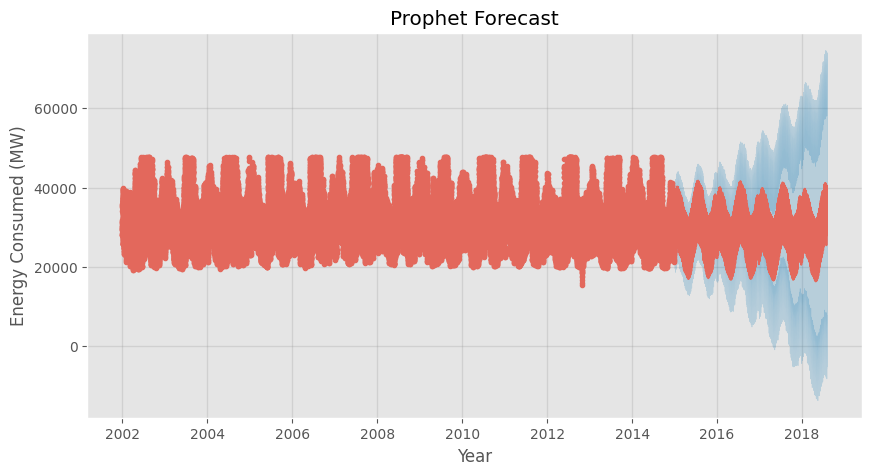

In [137]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
for line in ax.get_lines():
    line.set_color(colour_pal[1])
plt.show()

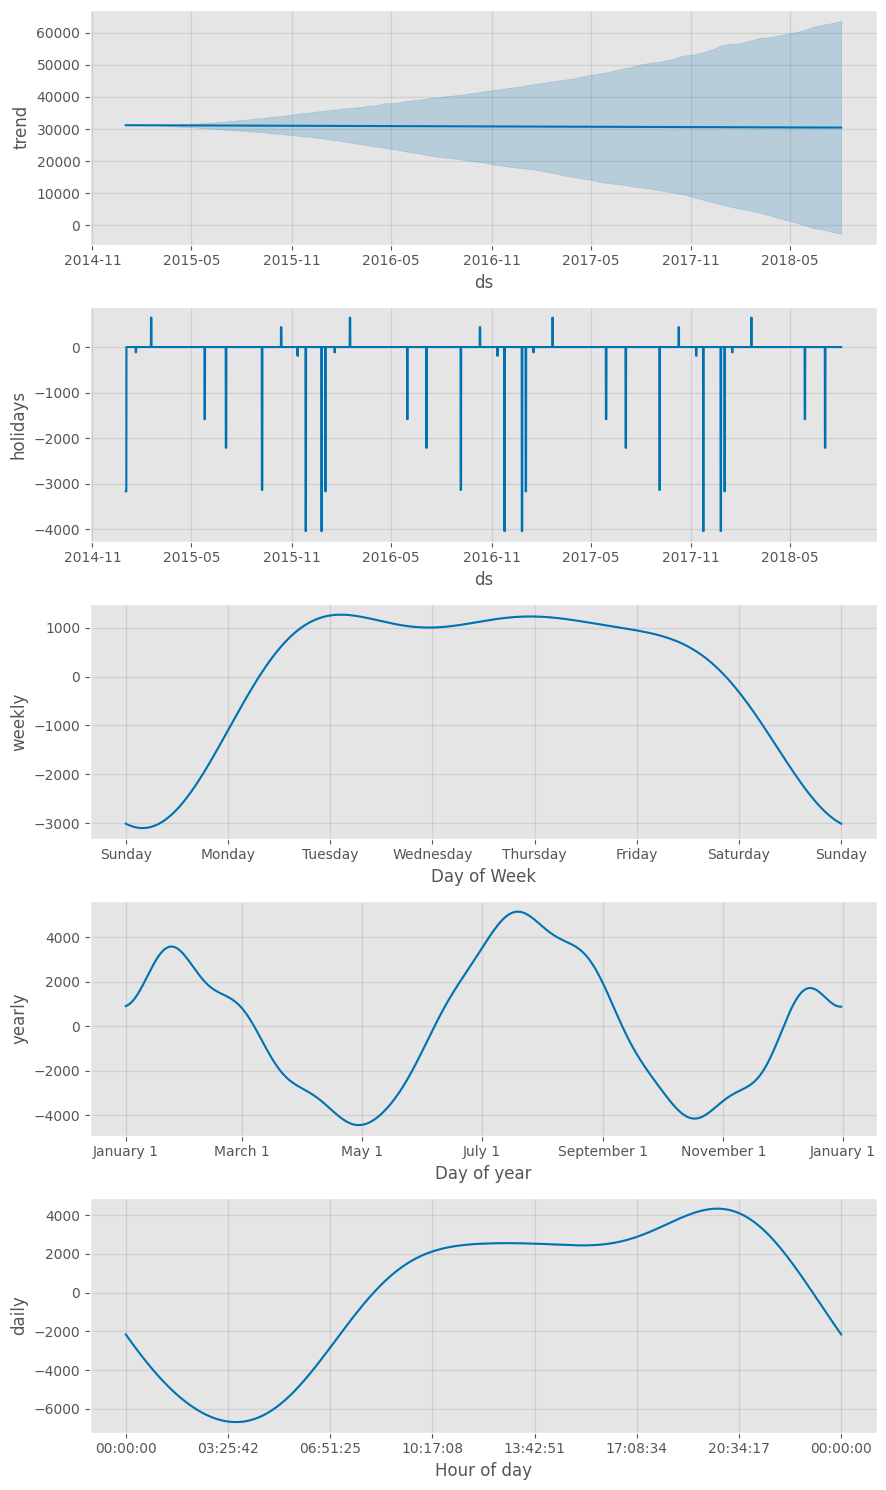

In [138]:

fig = model.plot_components(pjme_test_fcst)


### Visual Comparison of Forecast to Test

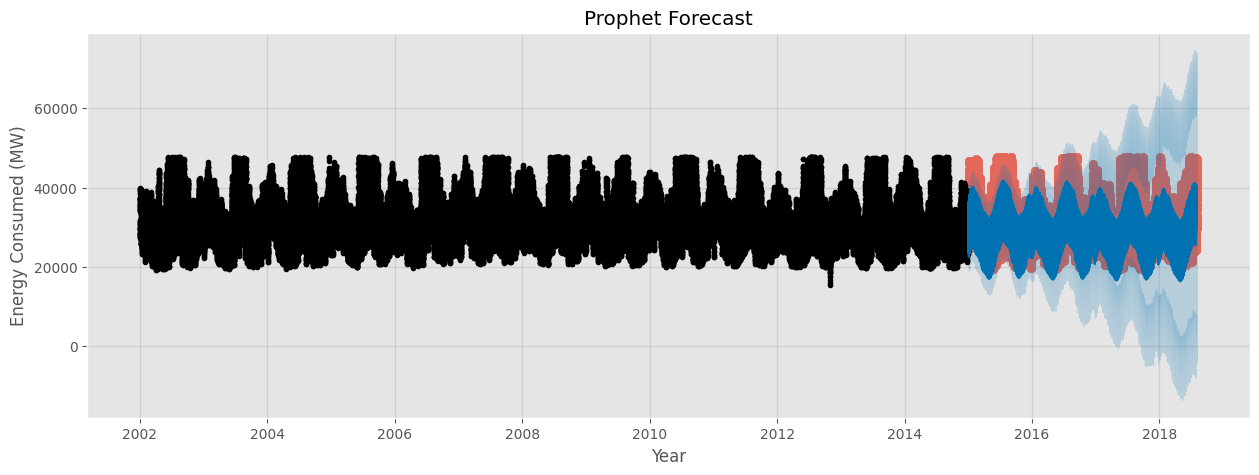

In [139]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

#### For One Month

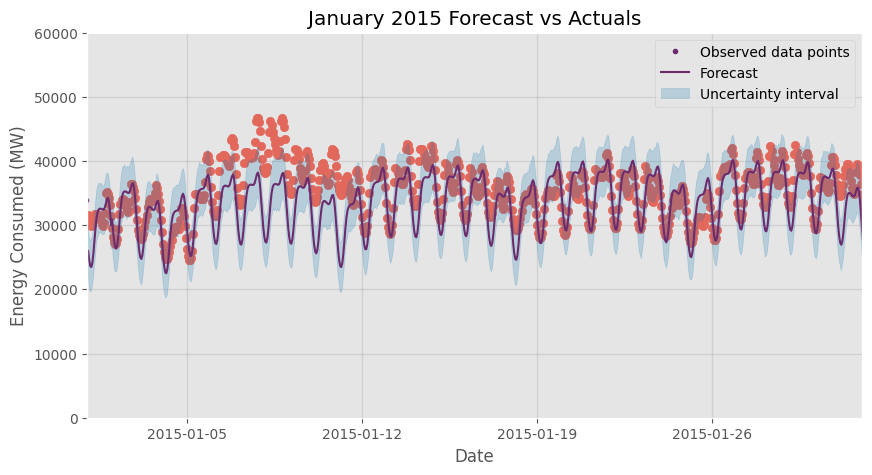

In [144]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = model.plot(pjme_test_fcst, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set(title='January 2015 Forecast vs Actuals',
       xlabel='Date', ylabel='Energy Consumed (MW)')
ax.legend()
plt.show()

#### For One Week

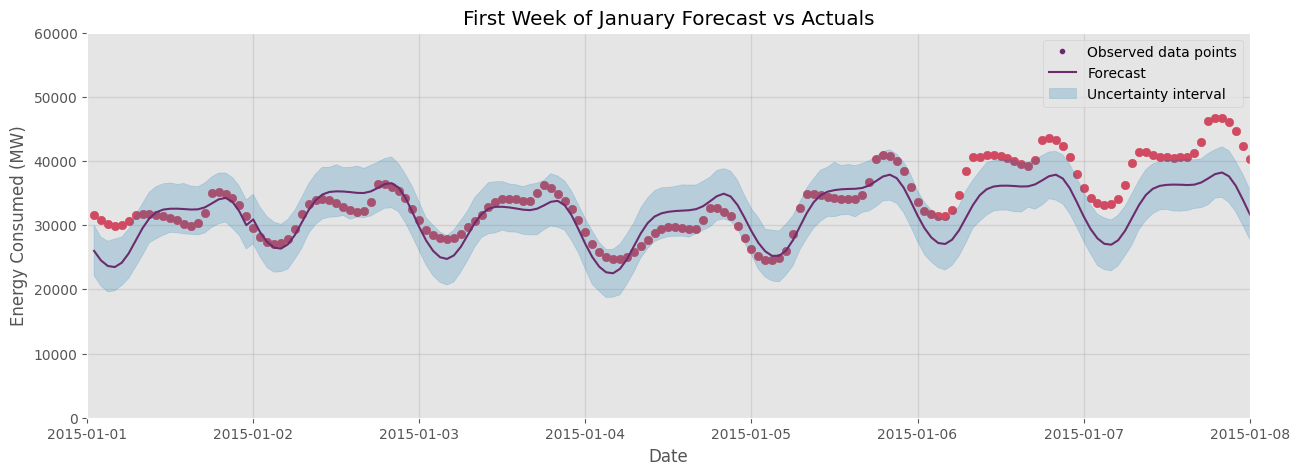

In [143]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[2])
fig = model.plot(pjme_test_fcst, ax=ax)
for line in ax.get_lines():
    line.set_color(colour_pal[5])
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
ax.legend()
ax.set(title='First Week of January Forecast vs Actuals', xlabel='Date', ylabel='Energy Consumed (MW)')
plt.show()

### Evaluate Simple Model (Error Metrics)

In [145]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat'])))

RMSE: 3739.154596764282


In [146]:
print('MSE:',mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat']))

MSE: 2884.562338691256


In [147]:
print('MAPE:',mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat']))

MAPE: 9.134498945740575


## Tuning Prophet Model Hyperparameters

In [151]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'growth': ['linear', 'logistic'],
    'yearly_seasonality': [5, 10, 20, 40],
    'weekly_seasonality': [5, 10, 20, 40],
    'daily_seasonality': [5, 10, 20, 40],
}

### Predict into Future

In [148]:
future = model.make_future_dataframe(
    periods=365*24, freq='h', include_history=False)
forecast = model.predict(future)

In [149]:
forecast[['ds', 'yhat']].head()

,ds,yhat
0,2015-01-01 00:00:00,27982.985261
1,2015-01-01 01:00:00,25996.450042
2,2015-01-01 02:00:00,24511.796952
3,2015-01-01 03:00:00,23639.515606
4,2015-01-01 04:00:00,23486.205842


### Saving Model for Later